# Imports

In [1]:
%reload_ext autoreload
%autoreload 2

import torch
import torchvision
import os
from utilities import utils, config, cuda, save_load
from dataset import dataset
from main_engine import engine, schedulers
from models import resnet
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import numpy as np
import albumentations as A
import matplotlib.pyplot as plt
from gradcam import GradCAMView
from main_engine.lr_finder import LRFinder
from dataset.tinyimagenet import TinyImageNetDataset
import cv2

In [2]:
#Initialize cuda
cuda, device = cuda.initialize_cuda(config.SEED)

GPU Available? True


# Visualize Dataset

In [3]:
imagenet_dataset = dataset.tinyimagenet_dataset('tiny-imagenet-200', download=False)

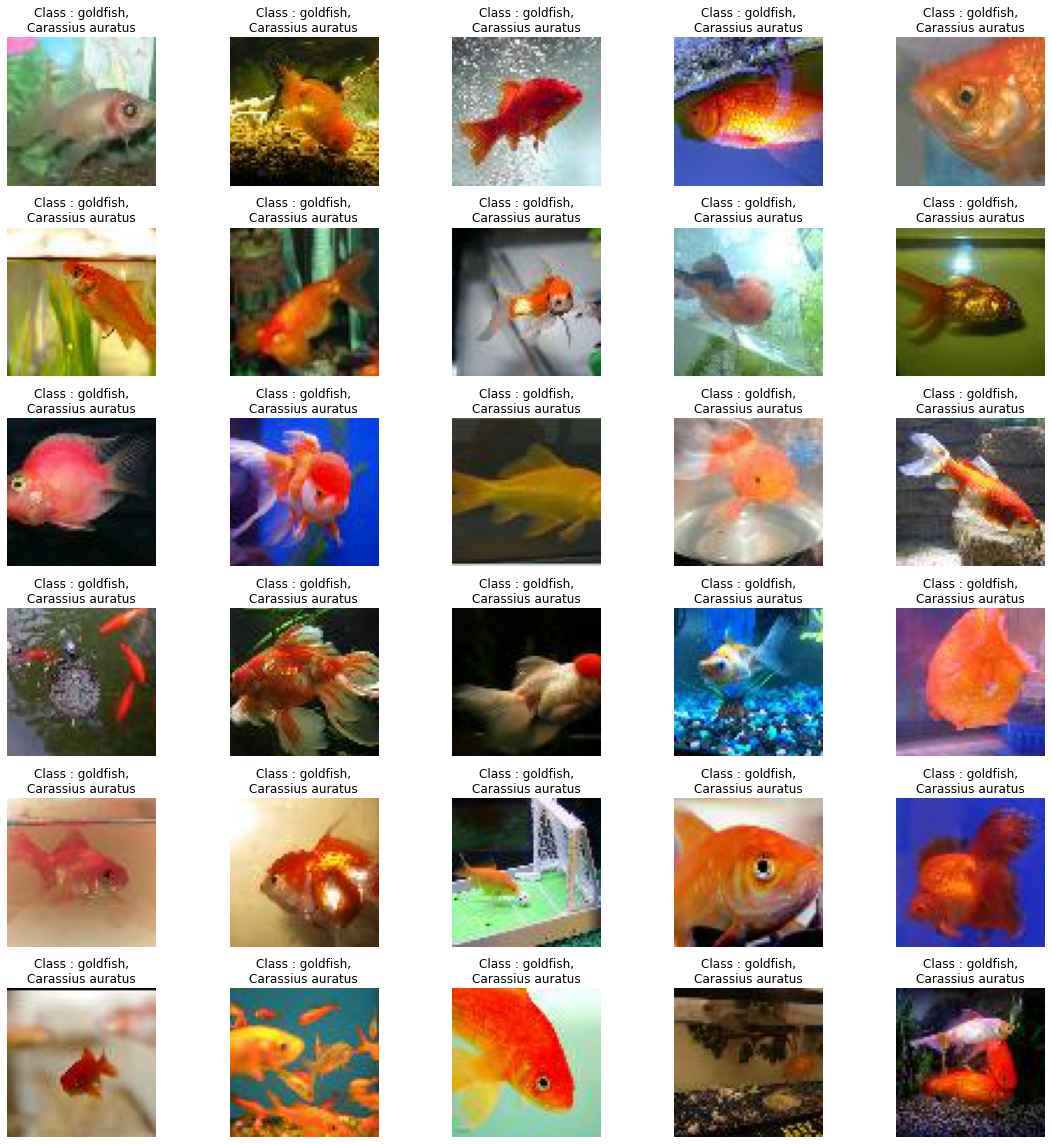

In [4]:
utils.show_imgs(imagenet_dataset, 30, (16, 16))

# Create DataLoader and Transformations

In [5]:
config.BATCH_SIZE = 256
config.EPOCHS = 50

In [6]:
mean, std = utils.get_stats(imagenet_dataset)[0], utils.get_stats(imagenet_dataset)[1]
print(mean, std)

(0.1489, 0.1489, 0.1489) (0.277, 0.2691, 0.2822)


In [7]:
transformations_list = [A.Normalize(mean, std)]
augmentations_list = [
                      A.PadIfNeeded(min_height=68, min_width=68, border_mode = cv2.BORDER_REFLECT, always_apply=True),
                      A.RandomCrop(height=64, width=64, always_apply=True),
                      A.HorizontalFlip(p=0.4),
                      A.Cutout(1,32, 32, fill_value=mean, p=0.3)
                     ]

In [8]:
trainset = dataset.tinyimagenet_dataset('tiny-imagenet-200', download=False, transforms=transformations_list, augmentations=augmentations_list)
testset = dataset.tinyimagenet_dataset('tiny-imagenet-200', download=False, transforms=transformations_list, train = False)
train_dl = dataset.data_loader(trainset, config.BATCH_SIZE, config.NUM_WORKERS, cuda, shuffle=True)
test_dl = dataset.data_loader(testset, config.BATCH_SIZE, config.NUM_WORKERS, cuda, shuffle=True)

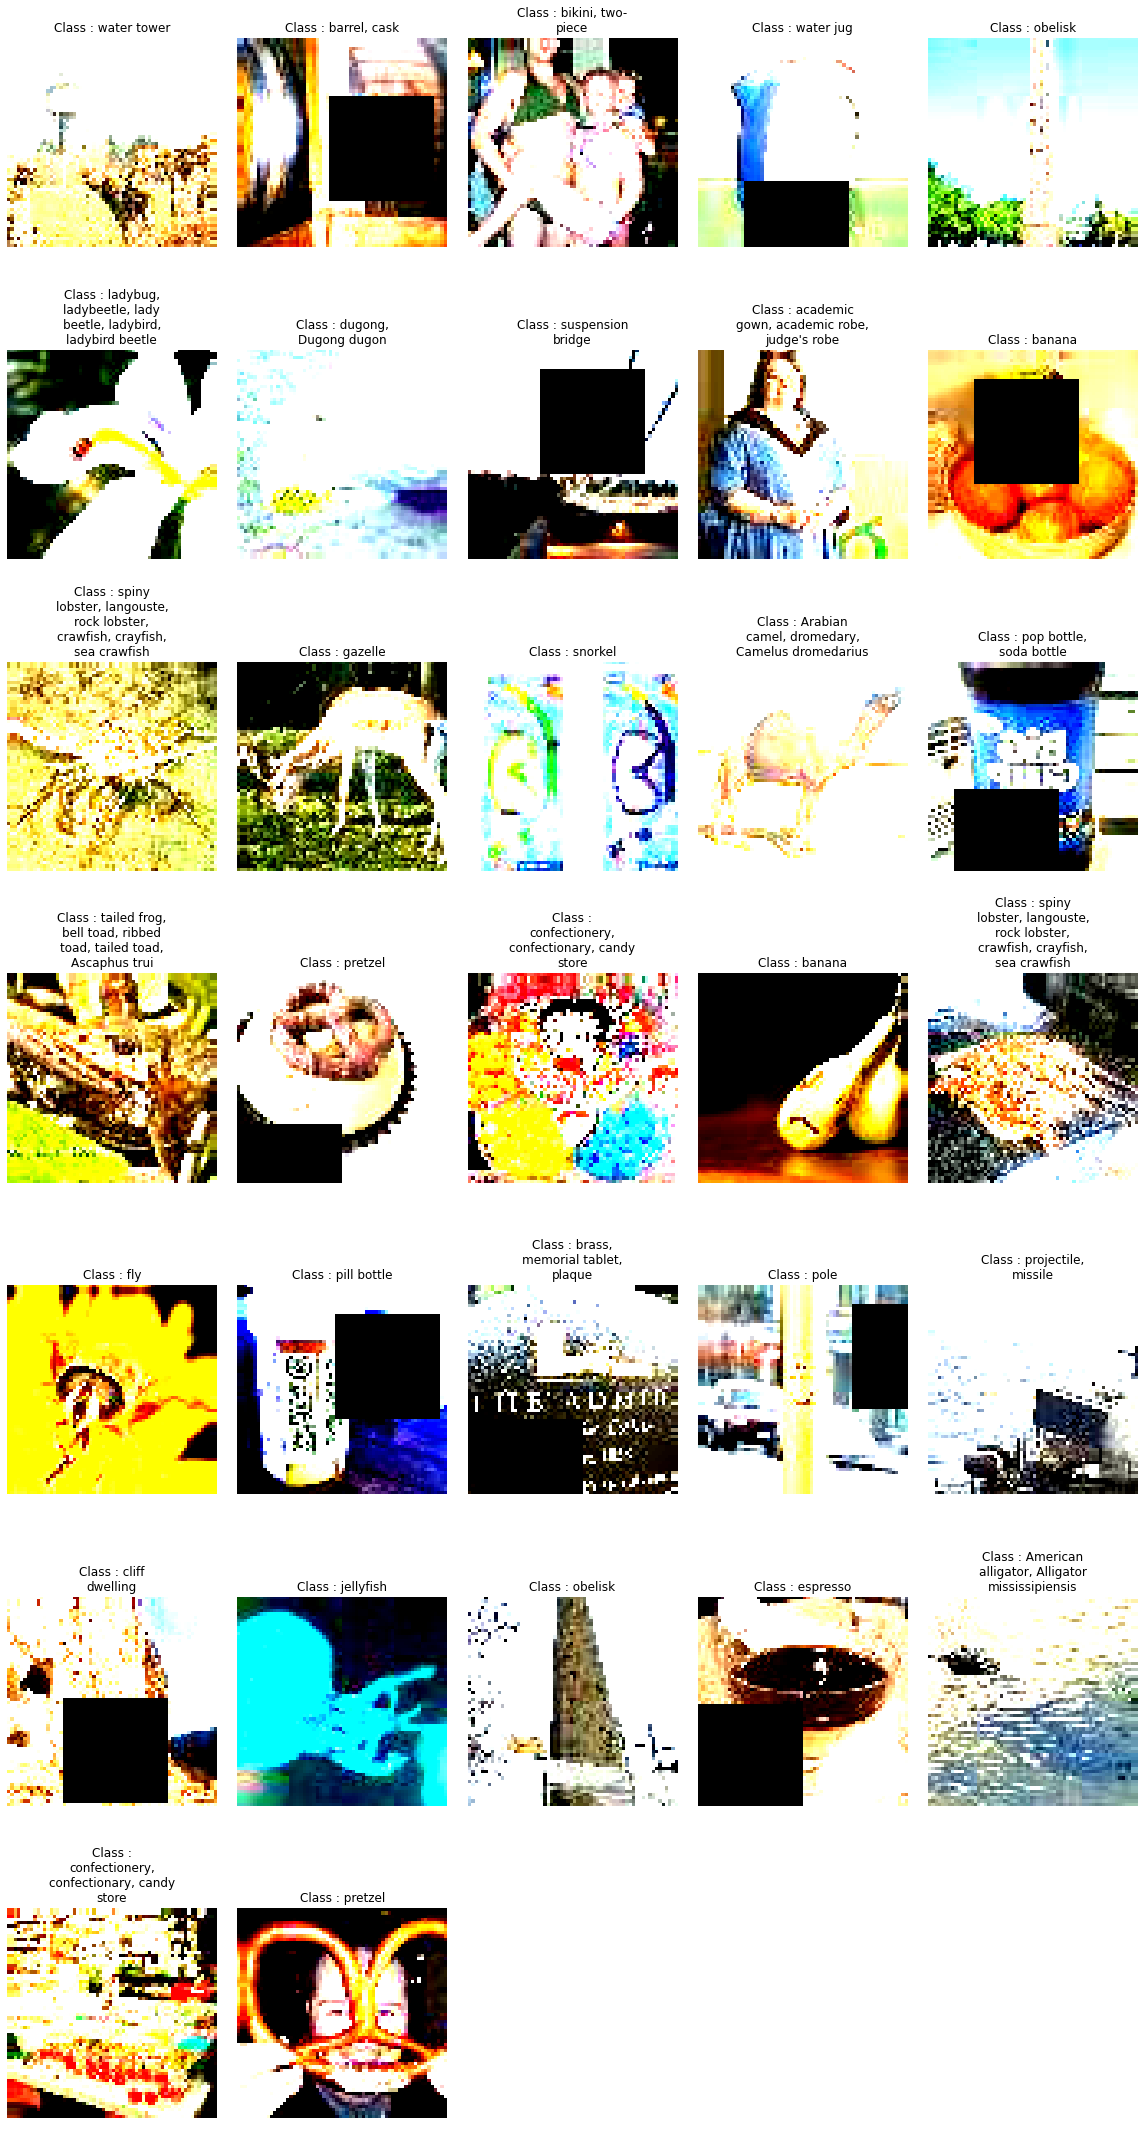

In [9]:
utils.show_batch(train_dl, (16, 30))

# Model Architecture

In [10]:
#Define model
model = resnet.ResNet18(num_classes=200).to(device)
utils.summary(model, (3, 64, 64))

torch.Size([2, 512])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           1,728
       BatchNorm2d-2           [-1, 64, 64, 64]             128
            Conv2d-3           [-1, 64, 64, 64]          36,864
       BatchNorm2d-4           [-1, 64, 64, 64]             128
            Conv2d-5           [-1, 64, 64, 64]          36,864
       BatchNorm2d-6           [-1, 64, 64, 64]             128
        BasicBlock-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
           Conv2d-10           [-1, 64, 64, 64]          36,864
      BatchNorm2d-11           [-1, 64, 64, 64]             128
       BasicBlock-12           [-1, 64, 64, 64]               0
           Conv2d-13          [-1, 128, 32, 32]          73,728
      BatchNorm2d-

# LR Range Test

In [11]:
model = resnet.ResNet18(num_classes=200).to(device)
loss_fn = utils.cross_entropy_loss_fn()
optimizer = utils.sgd_optimizer(model, lr=0.01)
lr_finder = LRFinder(model, optimizer, loss_fn, device)

In [12]:
lr_finder.range_test(train_dl, start_lr=0.002, end_lr=10, num_iter=len(train_dl)*50)

RuntimeError: CUDA out of memory. Tried to allocate 256.00 MiB (GPU 0; 4.00 GiB total capacity; 2.85 GiB already allocated; 45.30 MiB free; 2.87 GiB reserved in total by PyTorch)

In [ ]:
lr_finder.plot()

In [ ]:
optimizer = utils.sgd_optimizer(model, lr=7.64E-02)
if config.DEBUG == True:
    config.EPOCHS = 20

scheduler = schedulers.OneCylePolicy(optimizer, max_lr=7.64E-02, 
                                     epochs = config.EPOCHS, steps_per_epoch=len(train_dl), pct_start=5/config.EPOCHS, 
                                     anneal_strategy='linear', div_factor=8, final_div_factor=1)
test_loss = []
test_accuracy = []
train_losses = []
train_accuracy = []
misclassified_imgs = []
for epoch in range(config.EPOCHS):
    print(f"Running Epoch {epoch+1}/{config.EPOCHS}\n")
    engine.train(model, train_dl, optimizer, loss_fn, device, train_losses, train_accuracy)
    engine.test(model, test_dl, loss_fn, device, 25, test_loss, test_accuracy, misclassified_imgs)
    scheduler.step()

In [ ]:
#Saving Model
# save_load.save_model(model, "EVA5S9.pth")

In [ ]:
#Load Model and set to eval

#Initialize Model
model = resnet.ResNet18().to(device)

#Load the saved model
model = save_load.load_model(model, "models\EVA5S9.pth")

In [ ]:
one_batch = next(iter(test_dl))[0]
batch_imgs = []

for i in range(len(one_batch)):
    if i < 25:
        batch_imgs.append(one_batch[i])

In [ ]:
grad_cam = GradCAMView(
    model, ['layer3', 'layer4'],
    device, mean, std
)
image = batch_imgs
grad_cam(image, 'grad_cam', (8,8))

# Misclassified Images

In [ ]:
class_idx = trainset.class_to_idx
utils.plot_incorrect_images(misclassified_imgs, class_idx, plot_size=(8, 8))

# Validation Plots

In [ ]:
utils.plot_metrics([{'metric':test_loss, 'label':'Validation Loss'},
                    {'metric':train_losses, 'label':'Train Loss'}], "Loss")

In [ ]:
utils.plot_metrics([{'metric':test_accuracy, 'label':'Validation Accuracy'},
                    {'metric':train_accuracy, 'label':'Training Accuracy'}], "Accuracy")

In [ ]:
schedulers.plot_lr(0.01, 0.1, 1000, 100)